<h1>Coding Up a DenseNet Architecture</h1>

Based on research, DenseNet could be a good alternative to ResNet, particularly because it does not need to have as many parameters as ResNet. In this notebook, we will try and code up a DenseNet from [the paper](https://arxiv.org/pdf/1608.06993.pdf), and train it on our cell image classification task.

In [48]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from collections import OrderedDict
import numpy as np
import pandas as pd
import os
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

We see that the model architecture is as follows:

<img src="./images/DenseNet-Architecture.png" alt="DenseNet architecture from the paper">

We now strive to build that architecture.

In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Tuple, Optional, Union, Any

# Create Dense Layer Class
class DenseLayer(nn.Module):
    def __init__(
        self, num_input_features, growth_rate, bn_size, drop_rate
    ):
        super().__init__()

        # Batch Normalization, ReLU, and 1x1 Convolution (bottleneck layer)
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        # Batch Normalization, ReLU, and 3x3 Convolution
        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        # Dropout rate
        self.drop_rate = float(drop_rate)

    # Function to apply Batch Normalization, ReLU, and 1x1 Convolution
    def bn_function(self, inputs: List[torch.Tensor]) -> torch.Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))
        return bottleneck_output
    
    # Forward method of the DenseLayer
    def forward(self, input):
        if isinstance(input, torch.Tensor):
            prev_features = [input]
        else:
            prev_features = input

        # Apply Batch Normalization, ReLU, and 1x1 Convolution
        bottleneck_output = self.bn_function(prev_features)

        # Apply Batch Normalization, ReLU, and 3x3 Convolution
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))

        # Apply dropout if specified
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        
        # Return the output of the dense layer
        return new_features

In [86]:
# Create a Dense Block Class
class DenseBlock(nn.ModuleDict):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate):
        super().__init__()

        # Create the layers for the Dense Block
        for i in range(num_layers):
            layer = DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module(f"denselayer{i + 1}", layer)
    
    # Forward method of the DenseBlock
    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

In [87]:
# Create a Transition Layer
class Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

In [88]:
class DenseNet(nn.Module):

    def __init__(
        self,
        growth_rate = 32,
        block_config = (6, 12, 24, 16),
        num_init_features = 64,
        bn_size = 4,
        drop_rate = 0,
        num_classes = 1000,
    ):

        super().__init__()

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(1, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out

Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image: <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512 at 0x7FD4F99CACD0>, Label: tensor([], dtype=torch.int64)
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>


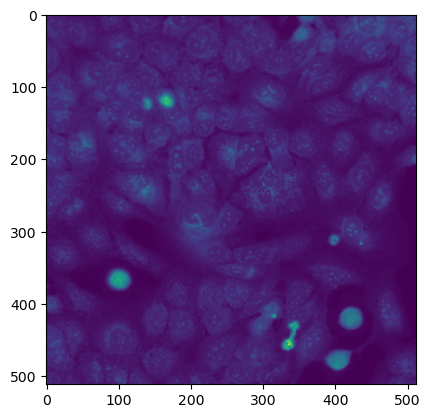

In [89]:
class ImageDataset(Dataset):
    def __init__(self, train=True, transform=None):
        postfix = 'train' if train else 'test'
        self.folder_path = f'data/{postfix}'
        self.df = pd.read_csv(f'data/train_with_target_id.csv') if train else pd.read_csv(f'data/{postfix}.csv')
        self.transform = transform
        self.file_list = self._get_file_list()

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = self.file_list[idx]
        img_path = os.path.join(self.folder_path, img_name)
        image = Image.open(img_path)
        label = torch.from_numpy(self.df.loc[self.df['id_code'] == img_name]['target_id'].values)

        if self.transform:
            image = self.transform(image)
        
        return image, label

    def _get_file_list(self):
        try:
            files = [file for file in os.listdir(self.folder_path) if file.endswith('.png')]
            return files
        except FileNotFoundError:
            print(f"The folder '{self.folder_path}' does not exist.")
            return []

    def _extract_label(self, filename):
        # Implement logic to extract label from filename or path
        # For example, if filenames are in the format "class_label_image.png"
        file_name = filename.split('_')
        label = file_name[0] + '_' + file_name[1] + '_' + file_name[2]
        # selected_row = self.df.loc[self.df['experiment'] == label]
        # return selected_row['sirna'].values[0]
        return label

# Example usage:
# Assuming you have a 'train' folder with PNG files in it
custom_dataset = ImageDataset()

# Accessing dataset elements
for i in range(len(custom_dataset)):
    sample = custom_dataset[i]
    print(f"Image: {sample[0]}, Label: {sample[1]}")
    print(f'Image shape: {type(sample[0])}')

    # Plotting the image
    plt.imshow(sample[0])
    plt.show()
    break

custom_dataset


In [90]:
# Instantiate the train and test datasets
train_dataset = ImageDataset(train=True, transform=transforms.ToTensor())
test_dataset = ImageDataset(train=False, transform=transforms.ToTensor())

# Instantiate DataLoader for train and test datasets
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Initialize the model
model = DenseNet()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 5  # Set the number of training epochs
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Initialize the tqdm progress bar
    tqdm_dataloader = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

    for batch in tqdm_dataloader:
        # Move batch to device
        images, labels = batch
        labels = labels
        print(type(images), labels)
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the tqdm progress bar description
        tqdm_dataloader.set_postfix(loss=loss.item())

    # Close the tqdm progress bar for the epoch
    tqdm_dataloader.close()

# Training complete
print("Training complete!")

Epoch 1/5:   0%|          | 0/10 [00:00<?, ?it/s]

Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
Image shape: <class 'PIL.PngImagePlugin.PngImageFile'>
Label shape: <class 'torch.Tensor'>
<class 'torch.Tensor'> tensor([], size=(10, 0), dtype=torch.int64)


KeyboardInterrupt: 

In [69]:
# Read in data
train = pd.read_csv('data/train.csv')

# Add a new column to train and test that is an integer representation of the label
train['target_id'] = train['sirna'].astype('category').cat.codes

train.to_csv('data/train_with_target_id.csv', index=False)
